In [2]:
%matplotlib inline

In [3]:
## Bring in needed mods
import pandas as pd, numpy as np, glob, os
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

from PIL import Image

import scipy.stats as ss, seaborn as sns

In [4]:
## Set random seed
np.random.seed(71191)

In [5]:
## Bring in more mods
from matplotlib.gridspec import GridSpec
plt.style.use(['tableau-colorblind10'])

In [6]:
## define ftns for use
def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP


def myminmax(x):
    x = np.array(x)
    return (x-x.min())/(x.max()-x.min())

In [7]:
## make labels of strains
from matplotlib import rc
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

In [8]:
## Bring in genotype data and find unique test loci
## Bring in genotype data
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(geno_path)

## find unique chromosomes, lengths, and midpoints. 
chrlist = sorted(gv.Chrom.unique())
chrlens = np.array([gv[(gv.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + gv[(gv.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos
assert len(chrlist) == 14

In [9]:
## Set variables
kb = 1000
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [13]:
## Bring in curated capsule data
datapath = '../DATA/PHENOTYPE/CAPSULE/Cdeneoformans_capsule_phenotypes.csv'
dgg = pd.read_csv(datapath)
dgg.drop('Sample.1',inplace=True,axis=1)
dgg.index = dgg.Sample
segs = dgg.Sample.unique()
assert dgg.Sample.unique().shape[0] == dgg.shape[0]
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL
Sample,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1.0
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1.0
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0.0
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1.0
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0.0


In [14]:
## take loci for use in QTL mapping
test = gv[segs].drop_duplicates()

In [15]:
## Define a list of the cell and capsule phenotypes
phenos = dgg.columns.tolist()[2:8]

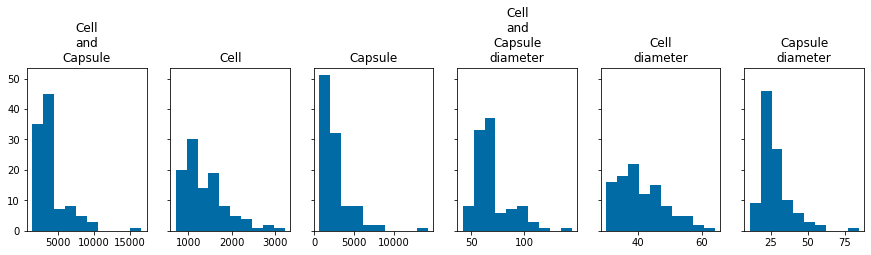

In [16]:
## Visulize the cell and capsule phenotypes
fig,ax = plt.subplots(1,len(phenos),figsize=(15,3),sharey=True)

for i,p in enumerate(phenos):
    
    plt.sca(ax.ravel()[i])
    plt.hist(dgg[p].values);
    plt.title('\n'.join(p.split('_')))

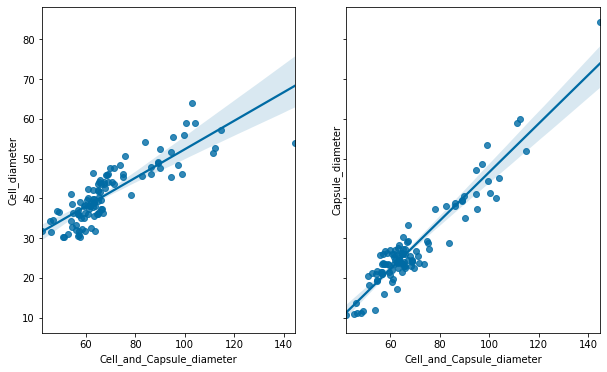

In [17]:
## Explore the allometric relationships
fig,ax = plt.subplots(1,2,figsize=(10,6),sharex=True,sharey=True);

plt.sca(ax[0]);
sns.regplot(x=phenos[3],y=phenos[4],data=dgg,order=1);

plt.sca(ax[1])
sns.regplot(x=phenos[3],y=phenos[5],data=dgg,order=1);

In [18]:
## Construct a linear model of Cell diameter based
## on total cell and capsule diamter
cell_lin_mod = smf.ols('Cell_diameter ~ Cell_and_Capsule_diameter',
                       data=dgg).fit()
cell_lin_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Cell_diameter   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     246.4
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           5.76e-29
Time:                        18:51:24   Log-Likelihood:                -291.17
No. Observations:                 104   AIC:                             586.3
Df Residuals:                     102   BIC:                             591.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    16.4867      1.625     10.144      0.000      13.263      19.710
Cell_and_Capsule_diameter     0.3587      0.023     15.698      0.000       0.313       0.404
==============================================================================
Omnibus:                        3.473   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.020
Skew:                          -0.259   Prob(JB):                        0.221
Kurtosis:                       3.654   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
## Test that the residuals from this model are normal
ss.shapiro(cell_lin_mod.resid)

ShapiroResult(statistic=0.9871662259101868, pvalue=0.42011958360671997)

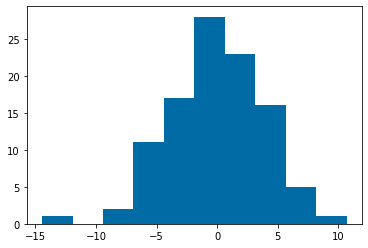

In [20]:
## Visulize the residuals of this model
plt.hist(cell_lin_mod.resid);

In [21]:
## Explore other non-linear models
from sklearn.preprocessing import PolynomialFeatures

In [22]:
## Reshape cell and capsule diameter
x = dgg[phenos[3]].values.reshape(-1,1)
x.shape

(104, 1)

In [23]:
## Make polynomial features
polynomial_features = PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(x)
xp.shape

(104, 3)

In [24]:
## Bring in additonal mods
import statsmodels.api as sm

In [25]:
## Construct non-linear models
model = sm.OLS(dgg[phenos[4]].values, xp).fit()
ypred = model.predict(xp) 

ypred.shape

(104,)

In [26]:
## Test if residuals are normal
ss.shapiro(model.resid)

ShapiroResult(statistic=0.9902018308639526, pvalue=0.6548328995704651)

In [27]:
## View model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     160.0
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           4.94e-32
Time:                        18:51:28   Log-Likelihood:                -280.83
No. Observations:                 104   AIC:                             567.7
Df Residuals:                     101   BIC:                             575.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3900      5.072     -1.260      0.211     -16.452       3.672
x1             0.9545      0.128      7.453      0.000       0.700       1.209
x2            -0.0036      0.001     -4.715      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        0.984   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                1.003
Skew:                           0.105   Prob(JB):                        0.606
Kurtosis:                       2.567   Cond. No.                     8.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

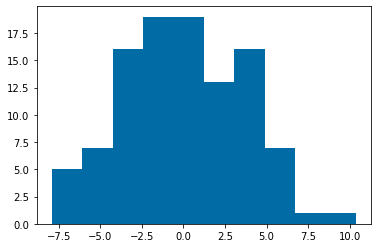

In [28]:
## Visualize residuals from non-linear model
plt.hist(model.resid);

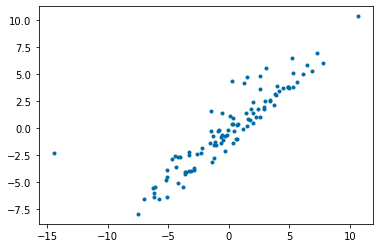

In [29]:
## Compare the two sets of residuals
plt.plot(cell_lin_mod.resid,model.resid,'.');

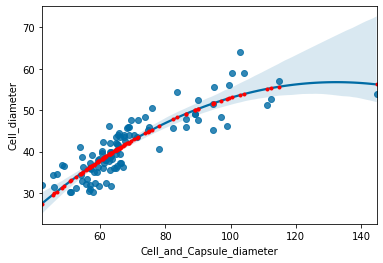

In [30]:
## Plot a second order polynomial regression
sns.regplot(x=phenos[3],y=phenos[4],data=dgg,order=2);
plt.plot(dgg[phenos[3]],ypred,'r.');

In [31]:
## Construct model of Capsule diameter as a ftn of
## total cell and capsule diameter and view results
caps_mod = smf.ols('Capsule_diameter ~ Cell_and_Capsule_diameter',
                   data=dgg).fit()
caps_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Capsule_diameter   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     828.7
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           8.93e-51
Time:                        18:51:31   Log-Likelihood:                -283.42
No. Observations:                 104   AIC:                             570.8
Df Residuals:                     102   BIC:                             576.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -14.4648      1.508     -9.589      0.000     -17.457     -11.473
Cell_and_Capsule_diameter     0.6105      0.021     28.787      0.000       0.568       0.653
==============================================================================
Omnibus:                        0.228   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.408
Skew:                           0.035   Prob(JB):                        0.816
Kurtosis:                       2.701   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
## Append to the dataframe as columns 
## the residuals from the above models
dgg['Predicted'] = caps_mod.predict()
dgg['Cell_Diameter_Residual'] = cell_lin_mod.resid
dgg['Capsule_Diameter_Residual'] = caps_mod.resid

In [33]:
## Conduct QTL mapping for each phenotype
for p in phenos:

    test[p] = test[segs].apply(association_logPval,
                               args=[dgg.T[segs].T[p]],
                               axis=1)
pval_df = gv.merge(test)

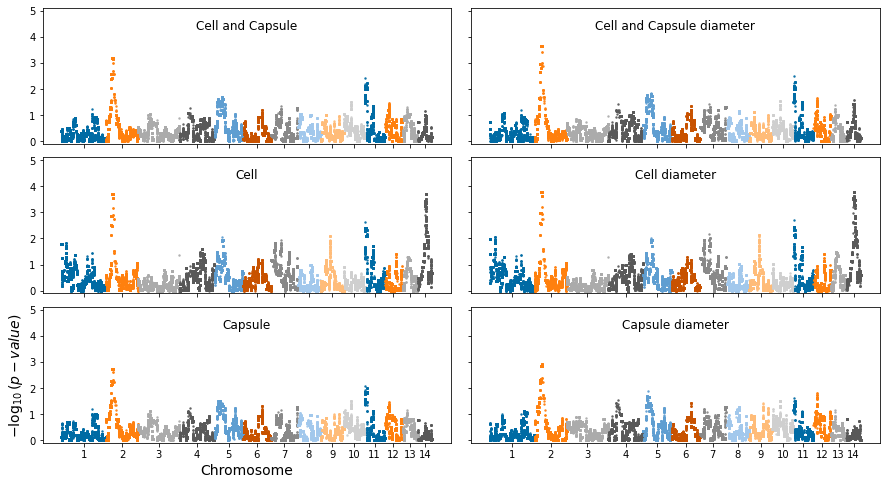

In [34]:
## Plot the QTL mapping results per phenotype
fig,ax = plt.subplots(3,2,figsize=(15,8),sharex=True,sharey=True)

plot_map = [0,2,4,1,3,5]
for i,p in enumerate(phenos):
    plt.sca(ax.ravel()[plot_map[i]])
    plt.title(' '.join(p.split('_')),y=.8)
    plt.xticks(chrmid,1+np.arange(len(chrlist)))
    
    for c,chrom in enumerate(chrlist):
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,alpha=0.8)
plt.ylim(-0.1,5.1)
plt.subplots_adjust(hspace=0.1,wspace=0.05)
plt.sca(ax[-1,0])
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosome',fontsize=14);

In [35]:
residuals_phenos = ['Cell_Diameter_Residual',
       'Capsule_Diameter_Residual']

In [36]:
## Conduct QTL mapping on cell and capsule phenotypes
for p in residuals_phenos:

    test[p] = test[segs].apply(association_logPval,
                               args=[dgg.T[segs].T[p]],
                               axis=1)
    pval_df[p] = gv.merge(test)[p]

In [37]:
## Check pvalue dataframe
pval_df.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B564,SS-B382,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Cell_Diameter_Residual,Capsule_Diameter_Residual
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,0.407254,1.777129,0.139142,0.747044,1.964845,0.136843,2.027621,2.32446


In [39]:
## Set variables for permutation 
kbs = 10000 ## Number
p = 'Cell_Diameter_Residual' ## Phenotype
permsavepath = '../DATA/PERMUTATIONS/%s_%s_null.csv.gz'%(p,kbs) ## Save path
## Run permutations 
## Uncomment and change the phenotypical values 
if not os.path.exists(permsavepath):
    perms = []
    while len(perms) < kbs:
    
        perms.append(test[segs].apply(association_logPval,
                        args=[np.random.permutation(dgg.T[segs].T[p].values)],
                               axis=1).max())
    ## Save perms    
    pd.DataFrame(perms).to_csv(permsavepath,index=False)
else:
    pass

In [40]:
## Set partial load path; requires pheontype and number of perms
permloadpath = '../DATA/PERMUTATIONS/%s_%s_null.csv.gz' 

In [41]:
## Load permutation results for capsule residual phenotype
p = 'Capsule_Diameter_Residual' ## Set Phenotype
perms = pd.read_csv(permloadpath%(p,kbs))['0'].tolist()

## Set 95th and 99th percentile
cap_res_99 = np.percentile(perms,99)
cap_res_95 = np.percentile(perms,95)
cap_res_95, cap_res_99

(4.21587966498493, 4.997605688370235)

In [42]:
## Load permutation results for capsule residual phenotype
p = 'Cell_Diameter_Residual' ## Set Phenotype
perms = pd.read_csv(permloadpath%(p,kbs))['0'].tolist()

## Set 95th and 99th percentile
#cell_res_95 = 4.68
cell_res_99 = np.percentile(perms,99)
cell_res_95 = np.percentile(perms,95)
cell_res_95, cell_res_99

(4.148666225570317, 4.8862782145750385)

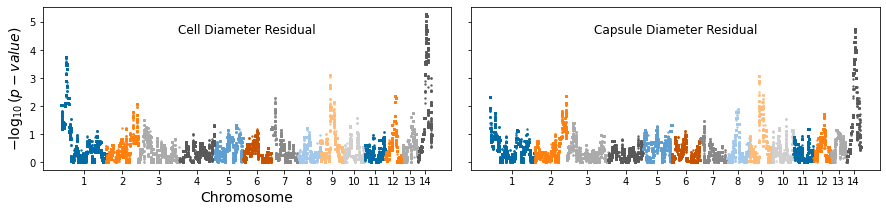

In [43]:
## Plot QTL mapping results on residuals
fig,ax = plt.subplots(1,2,figsize=(15,3),sharex=True,sharey=True)


for i,p in enumerate(residuals_phenos):
    plt.sca(ax.ravel()[i])
    plt.title(' '.join(p.split('_')),y=.8)
    plt.xticks(chrmid,1+np.arange(len(chrlist)))
    
    for c,chrom in enumerate(chrlist):
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,alpha=0.8)
        
    
    #plt.hlines(5.05,0,19*(10**6),linewidth=0.5,linestyle='--')
plt.sca(ax[0])
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosome',fontsize=14)
plt.subplots_adjust(hspace=0.1,wspace=0.05)

In [44]:
## Gather chromsome 14 data
ch14 = pval_df[(pval_df.Chrom=='Chr14')]

In [45]:
## Gather genotypes at QTL peak for capsule residuals
caps_diam_qtl = pval_df.T[ch14['Capsule_Diameter_Residual'].idxmax()].T[segs]

In [46]:
## Gather genotypes at QTL peak for cell residuals
cell_diam_qtl = pval_df.T[ch14['Cell_Diameter_Residual'].idxmax()].T[segs]

In [47]:
## Append data to data df
dgg['Cell_Diameter_Residual_QTL'] = cell_diam_qtl
dgg['Capsule_Diameter_Residual_QTL'] = caps_diam_qtl
dgg['Chromosome 14\nQTL Allele'] = [_431_label if a == 1 else xl280_label 
                                    for a in dgg.Cell_Diameter_Residual_QTL]

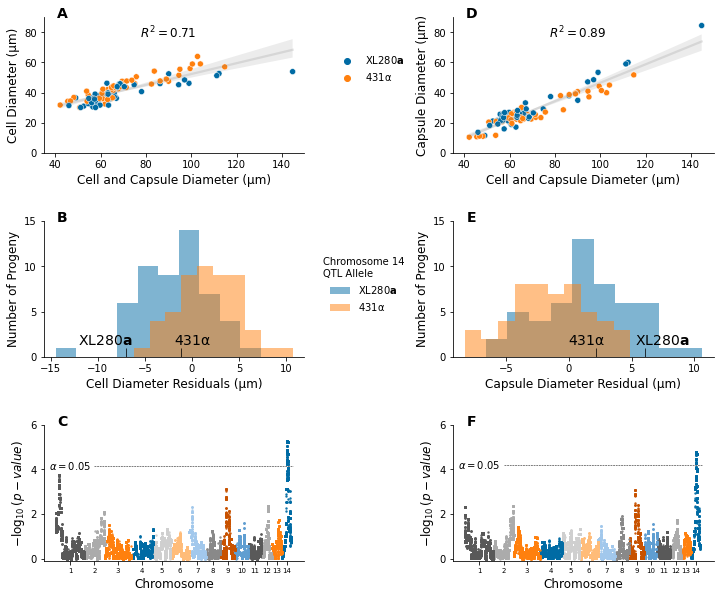

In [48]:
fig,ax = plt.subplots(3,2,figsize=(12,10))
plt.sca(ax[0,0])
plt.title('A',x=0.07,y=.95,fontsize=14,fontweight='bold')
sns.regplot(x='Cell_and_Capsule_diameter',y='Cell_diameter',
            data=dgg,order=1,scatter_kws={'alpha':0.0},
            line_kws={'color':'grey','alpha':0.2});

sns.scatterplot(x='Cell_and_Capsule_diameter',y='Cell_diameter',
                hue='Chromosome 14\nQTL Allele',data=dgg,
                hue_order=[xl280_label,_431_label],legend=None);

plt.xlabel('Cell and Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylabel('Cell Diameter (\u03BCm)',fontsize=12)
plt.ylim(0,90)
plt.text(x=90,y=80,s='$R^2 = %s$'%np.round(cell_lin_mod.rsquared,2),
         va='center',ha='center',fontsize=12)
plt.xlim(35,150)

plt.sca(ax[1,0])
plt.title('B',x=0.07,y=.95,fontsize=14,fontweight='bold')

plt.hist(dgg[(dgg.Cell_Diameter_Residual_QTL==0)
            ].Cell_Diameter_Residual.values,alpha=0.5,label=xl280_label)
plt.hist(dgg[(dgg.Cell_Diameter_Residual_QTL==1)
            ].Cell_Diameter_Residual.values,alpha=0.5,label=_431_label)
plt.ylabel('Number of Progeny',fontsize=12)
plt.ylim(0,15)
plt.yticks(np.arange(0,20,5))



plt.xlabel('Cell Diameter Residuals (\u03BCm)',fontsize=12)

plt.vlines(dgg.T[['XL280a','SS-A837']].T.Cell_Diameter_Residual.values,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Cell_Diameter_Residual-0.75,y=1,
         s=_431_label,fontsize=14,va='bottom',ha='left')
plt.text(x=dgg.T['XL280a'].T.Cell_Diameter_Residual+0.75,y=1,
         s=xl280_label,fontsize=14,va='bottom',ha='right');


plt.sca(ax[0,1])
plt.title('D',x=0.07,y=.95,fontsize=14,fontweight='bold')

sns.regplot(x='Cell_and_Capsule_diameter',y='Capsule_diameter',
            data=dgg,order=1,scatter_kws={'alpha':0.0},
            line_kws={'color':'grey','alpha':0.2});

sns.scatterplot(x='Cell_and_Capsule_diameter',y='Capsule_diameter',
                hue='Chromosome 14\nQTL Allele',data=dgg,
                hue_order=[xl280_label,_431_label]);
plt.legend(frameon=False,bbox_to_anchor=(-.15,.8))

plt.xlabel('Cell and Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylabel('Capsule Diameter (\u03BCm)',fontsize=12)
plt.ylim(0,90)
plt.text(x=90,y=80,s='$R^2 = %s$'%np.round(caps_mod.rsquared,2),
         va='center',ha='center',fontsize=12)

plt.xlim(35,150)

plt.sca(ax[1,1])
plt.title('E',x=0.07,y=.95,fontsize=14,fontweight='bold')

plt.hist(dgg[(dgg.Capsule_Diameter_Residual_QTL==0)
            ].Capsule_Diameter_Residual.values,alpha=0.5,label=xl280_label)
plt.hist(dgg[(dgg.Capsule_Diameter_Residual_QTL==1)
            ].Capsule_Diameter_Residual.values,alpha=0.5,label=_431_label)


plt.legend(title='Chromosome 14\nQTL Allele',
           fontsize=10,frameon=False,bbox_to_anchor=(-.15,.8))
plt.ylabel('Number of Progeny',fontsize=12)
plt.xlabel('Capsule Diameter Residual (\u03BCm)',fontsize=12)
plt.ylim(0,15)
plt.yticks(np.arange(0,20,5))
plt.vlines(dgg.T[['XL280a','SS-A837']].T.Capsule_Diameter_Residual.values,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Capsule_Diameter_Residual+0.75,y=1,
         s=_431_label,fontsize=14,va='bottom',ha='right')
plt.text(x=dgg.T['XL280a'].T.Capsule_Diameter_Residual-0.75,y=1,
         s=xl280_label,fontsize=14,va='bottom',ha='left');

thresholds = [cell_res_95,cap_res_95]
QTL_color= ['tab:orange','tab:blue']
for i,p in enumerate(residuals_phenos):
    plt.sca(ax[-1,i])
    plt.title('C' if i == 0 else 'F',x=0.07,y=.95,fontsize=14,fontweight='bold')

    plt.xticks(chrmid,1+np.arange(len(chrlist)),fontsize=7)
    plt.hlines(thresholds[i],chrmid[1],19*(10**6),
               linestyle='--',linewidth=0.5,color='k')
    
    plt.text(x=chrmid[0],y=thresholds[i],
             s=r'$\alpha = 0.05$',va='center',ha='center')
    
    for c,chrom in enumerate(chrlist[::-1]):
        c = 13 -c
        temp = pval_df[(pval_df.Chrom==chrom)][['Pos',p]]
        
        plt.plot(temp.Pos+cumpos[c],temp[p],'.',ms=3,
                 alpha=0.8)
                 #color=QTL_color[i] if chrom == 'Chr14' 
                 #else chrom_colors[c%len(chrom_colors)])
        
    plt.ylim(-0.1,6)
    plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);
    plt.xlabel('Chromosome',fontsize=12)


for i in range(6):
    [ax.ravel()[i].spines[a].set_visible(False) for a in ['top','right']]

plt.subplots_adjust(hspace=0.5,wspace=0.57)
plt.savefig('../FIGURES/SUPP/PDFs/S2_Fig.pdf',
            dpi=300,bbox_inches='tight');

In [49]:
## Append qtl genotype
dgg['QTL'] = dgg['Capsule_Diameter_Residual_QTL']

## Save out data
dgg.to_csv('../DATA/PHENOTYPE/Capsule_Phenotypes_QTL.csv.gz',index=False)

## View first 5 rows
dgg.head()

,Sample,Date,Cell_and_Capsule,Cell,Capsule,Cell_and_Capsule_diameter,Cell_diameter,Capsule_diameter,Circles,Residual,QTL,Predicted,Cell_Diameter_Residual,Capsule_Diameter_Residual,Cell_Diameter_Residual_QTL,Capsule_Diameter_Residual_QTL,Chromosome 14\nQTL Allele
Sample,,,,,,,,,,,,,,,,,
SS-A837,SS-A837,7-120,2954.0,1093.0,1935.5,61.323907,37.304177,25.117309,15,2.144624,1,22.972684,-1.179139,2.144624,1,1,431$\mathrm{\alpha}$
SS-B307,SS-B307,7-120,3015.0,831.0,2065.5,61.958189,32.512533,26.994920,15,3.635013,1,23.359906,-6.198297,3.635013,1,1,431$\mathrm{\alpha}$
SS-B310,SS-B310,7-120,6371.0,2168.0,3964.5,90.064104,52.517844,34.967517,15,-5.550718,0,40.518235,3.725538,-5.550718,0,0,XL280$\bf{a}$
SS-B311,SS-B311,7-150,3293.5,1023.5,2096.5,64.756295,36.099316,26.319158,15,1.251042,1,25.068117,-3.615184,1.251042,1,1,431$\mathrm{\alpha}$
SS-B312,SS-B312,11-22,7008.5,1610.0,5398.5,94.452263,45.269625,47.179251,15,3.982097,0,43.197154,-5.096695,3.982097,0,0,XL280$\bf{a}$


In [50]:
## Calculate heritability
mod_res = smf.ols('Capsule_Diameter_Residual ~ QTL',data=dgg).fit()
cap_res_r = np.round(mod_res.rsquared,2)
cap_res_r

0.17

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "compression" which is no longer supported as of 3.3 and will become an error two minor releases later


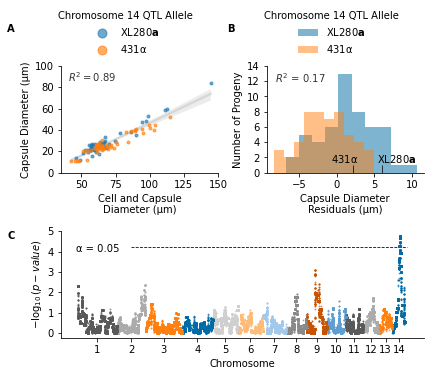

In [52]:
## Generate Figure 2 with mods proposed by reviewer 2
residual_threshold = 4.1267
width = 6.5
height = 5
fig = plt.figure(figsize=(width,height))
gs = fig.add_gridspec(2,4)
fs = 10
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,:])

plt.sca(ax1)
[ax1.spines[a].set_visible(False) for a in ['top','right']]
x = 'Cell_and_Capsule_diameter'
y = 'Capsule_diameter'
plt.text(40,90,'$R^2 = %s$'%np.round(caps_mod.rsquared,2),
         fontsize=fs,color='k',va='center',alpha=.8)

sns.regplot(x=x,y=y,
           data=dgg,order=1,
           line_kws={'color':'grey','alpha':.2}, 
           scatter_kws={'color':'k','alpha':0.0});
plt.xlim(35,150)
plt.plot(dgg[(dgg.QTL==0)][x].values,
         dgg[(dgg.QTL==0)][y].values,'.',
         color='tab:blue',alpha=0.64,label=xl280_label)

plt.plot(dgg[(dgg.QTL==1)][x].values,
         dgg[(dgg.QTL==1)][y].values,'.',
         color='tab:orange',alpha=0.64,label=_431_label)

plt.legend(title='Chromosome 14 QTL Allele',markerscale=3.0,
           fontsize=fs, bbox_to_anchor=(0.9,1.6),frameon=False)

plt.ylabel('Capsule Diameter (\u03BCm)',fontsize=fs)
plt.xlabel('Cell and Capsule\nDiameter (\u03BCm)',fontsize=fs)
plt.yticks(np.arange(0,120,20))    

plt.sca(ax2)

for i, a in enumerate(dgg.groupby('QTL')):
    
    plt.hist(a[1].Residual,alpha=0.5,bins=10,
    label=xl280_label if i == 0 else _431_label);

plt.vlines(dgg.T[['XL280a','SS-A837']].T.Residual,
           0,1,color='k',linewidth=1,alpha=0.75);
plt.text(x=dgg.T['SS-A837'].T.Residual+0.75,y=1,
         s=_431_label,fontsize=fs,va='bottom',ha='right')
plt.text(x=dgg.T['XL280a'].T.Residual-0.75,y=1,
         s=xl280_label,fontsize=fs,va='bottom',ha='left');
plt.xlabel('Capsule Diameter\nResiduals (\u03BCm)',fontsize=fs);
plt.ylabel('Number of Progeny',fontsize=fs);
plt.yticks(np.arange(0,16,2))
plt.legend(title='Chromosome 14 QTL Allele',
           fontsize=fs, bbox_to_anchor=(0.9,1.6),frameon=False)
[ax2.spines[a].set_visible(False) for a in ['top','right']]
plt.text(-1.5,12.4,s='$R^2$ = %s'%cap_res_r,va='center',
         ha='right',fontsize=fs,rasterized=True,
         color='k',alpha=.8)

###### ----------------------------------------------------------- ######
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']
plt.sca(ax3)
[ax3.spines[a].set_visible(False) for a in ['top','right']]
for c in chrlist[::-1]:
    i = int(c[-2:]) -1
    #if c == 'Chr14':
    #    cc = 'tab:blue'
    #else:
    #    cc = chrom_colors[i%len(chrom_colors)]
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],
             temp.Capsule_Diameter_Residual.values,
             '.',alpha=0.5,markersize=2)#,color=cc)
plt.hlines(cap_res_95, chrmid[1],19*(10**6),linestyle='--',
           linewidth=0.8,color='k')#,label='\u03B1 = 0.01')
plt.xticks(chrmid,[int(a[-2:]) for a in chrlist]);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=fs);
plt.xlabel('Chromosome',fontsize=fs)
plt.text(x=chrmid[0],y=residual_threshold ,s='\u03B1 = 0.05',
         va='center',ha='center',fontsize=fs)   

plt.yticks(np.arange(6))
#### -------------- Label, adjust and save figure ---------------------- ##    
plt.subplots_adjust(wspace=0.9,hspace=0.55)


fig.text(0.01,.975,'A',fontsize=fs,fontweight='bold')
fig.text(0.48,.975,'B',fontsize=fs,fontweight='bold')
fig.text(0.01,.4,'C',fontsize=fs,fontweight='bold')

mydpi = 600
qtlpaper_save = '../FIGURES/MAIN/TIFF/Fig2.tiff'
plt.savefig(qtlpaper_save,
           dpi=mydpi,bbox_inches='tight',compression='tiff_lzw');

plt.savefig('../FIGURES/MAIN/PDFs/Fig2.pdf',
            dpi=mydpi,bbox_inches='tight',pad_inches=1)

im = Image.open(qtlpaper_save)
w,h = im.size

assert w/mydpi > 2.63
assert w/mydpi < 7.5
assert h/mydpi < 8.5
    
im.save(qtlpaper_save,compression='tiff_lzw')